In [3]:
import Pkg
Pkg.add("MathOptInterface")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [4]:
using Pkg
using CSV,DataFrames,Random
using GLM
using CPLEX,JuMP
using HypothesisTests,Plots,StatsPlots,Distributions
using MathOptInterface,Random
using TwoSD

# 1. SAA

#### 1.1 Descriptive Analytics

In [5]:
function partitionTrainTest(data, at = 0.5)
    n = nrow(data)
    idx = shuffle(1:nrow(data))
    train_idx = view(idx, 1:floor(Int, at*n))
    test_idx = view(idx, (floor(Int, at*n)+1):n)
    data[train_idx,:], data[test_idx,:]
end

partitionTrainTest (generic function with 2 methods)

In [6]:
df = DataFrame(CSV.File("Advertising1.csv"))

,Column1,TV,Radio,Newspaper,Sales
,Int64,Float64,Float64,Float64,Float64
1,1,230.1,37.8,69.2,22.1
2,2,44.5,39.3,45.1,10.4
3,3,17.2,45.9,69.3,9.3
4,4,151.5,41.3,58.5,18.5
5,5,180.8,10.8,58.4,12.9
6,6,8.7,48.9,75.0,7.2
7,7,57.5,32.8,23.5,11.8
8,8,120.2,19.6,11.6,13.2
9,9,8.6,2.1,1.0,4.8


In [7]:
train,test = partitionTrainTest(df)

(100×5 DataFrame
 Row │ Column1  TV       Radio    Newspaper  Sales   
     │ Int64    Float64  Float64  Float64    Float64 
─────┼───────────────────────────────────────────────
   1 │     155    187.8     21.1        9.5     15.6
   2 │      54    182.6     46.2       58.7     21.2
   3 │      41    202.5     22.3       31.6     16.6
   4 │     103    280.2     10.1       21.4     14.8
   5 │      70    216.8     43.9       27.2     22.3
   6 │     176    276.9     48.9       41.8     27.0
   7 │     145     96.2     14.8       38.9     11.4
   8 │     115     78.2     46.8       34.5     14.6
   9 │     186    205.0     45.1       19.6     22.6
  10 │      65    131.1     42.8       28.9     18.0
  11 │      31    292.9     28.3       43.2     21.4
  ⋮  │    ⋮        ⋮        ⋮         ⋮         ⋮
  91 │     106    137.9     46.4       59.0     19.2
  92 │      60    210.7     29.5        9.3     18.4
  93 │     139     43.0     25.9       20.5      9.6
  94 │      71    199.1     3

In [8]:
fm = @formula(Sales ~ TV + Radio)
linearRegressor = lm(fm, train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Sales ~ 1 + TV + Radio

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  2.68824     0.400429    6.71    <1e-08  1.8935     3.48298
TV           0.0454906   0.0017343  26.23    <1e-45  0.0420485  0.0489327
Radio        0.195616    0.0109858  17.81    <1e-31  0.173813   0.21742
─────────────────────────────────────────────────────────────────────────

In [9]:
ypredicted_test = predict(linearRegressor, test)

100-element Vector{Union{Missing, Float64}}:
 10.6525442590995
 19.44673512618945
 18.04195460368989
  9.835777722588563
  6.320214132259046
 14.799320591575066
  8.517142362235731
 14.928903033732947
 10.312557582846395
  6.8592738996254115
  7.231919765484033
 12.951155669595614
 18.424583507015313
  ⋮
 19.144686054299225
  5.149761880659329
 16.298328115736275
 18.176511281688164
  6.39901720257205
 10.362728556996938
 10.32066707499014
 10.857697731066173
 21.71950747561467
 12.932060692330104
  9.352727349724017
  9.029737407874048

In [10]:
ypredicted_train = predict(linearRegressor, train)

100-element Vector{Union{Missing, Float64}}:
 15.358875310331326
 20.0322948217895
 16.262326275111278
 17.410423856312455
 21.138154615544984
 24.85021948292672
  9.959556310181192
 15.40044939482505
 20.83610554365476
 17.024434999144354
 21.54837168843467
 23.397670408055966
  7.746875753958477
  ⋮
 20.68960241182299
 18.491955173636704
 18.03798972866167
 18.04378667006972
  9.710799642430462
 17.73127407635683
  8.85739521497138
 14.920402928276983
  5.977285768104297
 23.235694952775113
 17.208091072066168
 17.32463126518314

In [11]:
error_test = test.Sales .- ypredicted_test

100-element Vector{Float64}:
 -4.0525442590995
  0.25326487381055074
 -0.041954603689891456
  1.7642222774114362
  3.079785867740954
  0.10067940842493428
 -3.017142362235731
 -1.5289030337329468
  1.1874424171536049
  1.8407261003745878
  1.1680802345159673
 -0.35115566959561484
  0.7754164929846858
  ⋮
  0.2553139457007738
  2.4502381193406704
  0.6016718842637232
 -2.0765112816881626
 -0.7990172025720508
 -1.5627285569969374
  0.17933292500985942
 -2.857697731066173
  1.4804925243853297
 -0.43206069233010425
  1.5472726502759837
  1.4702625921259518

In [12]:
error_train = train.Sales .- ypredicted_train

100-element Vector{Float64}:
  0.2411246896686734
  1.1677051782105003
  0.3376737248887238
 -2.6104238563124547
  1.1618453844550167
  2.1497805170732818
  1.4404436898188084
 -0.8004493948250495
  1.7638944563452412
  0.9755650008556458
 -0.14837168843467197
  2.002329591944033
  1.9531242460415221
  ⋮
  1.9103975881770126
  1.1080448263632974
  1.1620102713383282
  0.3562133299302772
 -0.1107996424304627
  0.5687259236431714
 -0.3573952149713797
  0.07959707172301655
  1.2227142318957034
  1.164305047224886
 -0.20809107206616773
  0.6753687348168604

In [13]:
min_max_table = describe(train, :min, :max)

,variable,min,max
,Symbol,Real,Real
1,Column1,3,195
2,TV,4.1,296.4
3,Radio,1.3,49.4
4,Newspaper,0.9,100.9
5,Sales,3.2,27.0


In [14]:
L1,U1 = min_max_table[2,2],min_max_table[2,3]

(4.1, 296.4)

In [15]:
L2,U2 = min_max_table[3,2],min_max_table[3,3]

(1.3, 49.4)

In [16]:
beta0,beta1,beta2 = GLM.coef(linearRegressor)[1],GLM.coef(linearRegressor)[2],GLM.coef(linearRegressor)[3]

(2.688241698799437, 0.04549056742151611, 0.19561635306972333)

#### 1.2 Prescriptive Analytics

In [35]:
# create CPLEX Model
model = Model(CPLEX.Optimizer)
set_silent(model)

In [36]:
N = length(error_train)

100

In [37]:
@variables(model, begin 
    L1 <= X1 <= U1
    L2 <= X2 <= U2
    Ya[1:N] >= 0
    Yb[1:N] >= 0
    end)

(X1, X2, VariableRef[Ya[1], Ya[2], Ya[3], Ya[4], Ya[5], Ya[6], Ya[7], Ya[8], Ya[9], Ya[10]  …  Ya[91], Ya[92], Ya[93], Ya[94], Ya[95], Ya[96], Ya[97], Ya[98], Ya[99], Ya[100]], VariableRef[Yb[1], Yb[2], Yb[3], Yb[4], Yb[5], Yb[6], Yb[7], Yb[8], Yb[9], Yb[10]  …  Yb[91], Yb[92], Yb[93], Yb[94], Yb[95], Yb[96], Yb[97], Yb[98], Yb[99], Yb[100]])

In [38]:
@constraint(model,X1 + X2 <= 200)
@constraint(model,X1 - 0.5 * X2 >= 0)
for i in 1:N
    @constraint(model,Ya[i] <= 8)
    @constraint(model,2 * Yb[i] <= 24)
    @constraint(model,3 * Ya[i] + 2 * Yb[i] <= 36)
    @constraint(model,-beta1*X1 - beta2*X2 + Ya[i] + Yb[i] <= beta0 + error_train[i])
end

In [39]:
@objective(model, Max, -0.1*X1 - 0.5*X2 + 1/N * sum((3*Ya[i] + 5*Yb[i]) for i in 1:N))

-0.1 X1 - 0.5 X2 + 0.03 Ya[1] + 0.05 Yb[1] + 0.03 Ya[2] + 0.05 Yb[2] + 0.03 Ya[3] + 0.05 Yb[3] + 0.03 Ya[4] + 0.05 Yb[4] + 0.03 Ya[5] + 0.05 Yb[5] + 0.03 Ya[6] + 0.05 Yb[6] + 0.03 Ya[7] + 0.05 Yb[7] + 0.03 Ya[8] + 0.05 Yb[8] + 0.03 Ya[9] + 0.05 Yb[9] + 0.03 Ya[10] + 0.05 Yb[10] + 0.03 Ya[11] + 0.05 Yb[11] + 0.03 Ya[12] + 0.05 Yb[12] + 0.03 Ya[13] + 0.05 Yb[13] + 0.03 Ya[14] + 0.05 Yb[14] + 0.03 Ya[15] + 0.05 Yb[15] + 0.03 Ya[16] + 0.05 Yb[16] + 0.03 Ya[17] + 0.05 Yb[17] + 0.03 Ya[18] + 0.05 Yb[18] + 0.03 Ya[19] + 0.05 Yb[19] + 0.03 Ya[20] + 0.05 Yb[20] + 0.03 Ya[21] + 0.05 Yb[21] + 0.03 Ya[22] + 0.05 Yb[22] + 0.03 Ya[23] + 0.05 Yb[23] + 0.03 Ya[24] + 0.05 Yb[24] + 0.03 Ya[25] + 0.05 Yb[25] + 0.03 Ya[26] + 0.05 Yb[26] + 0.03 Ya[27] + 0.05 Yb[27] + 0.03 Ya[28] + 0.05 Yb[28] + 0.03 Ya[29] + 0.05 Yb[29] + 0.03 Ya[30] + 0.05 Yb[30] + 0.03 Ya[31] + 0.05 Yb[31] + 0.03 Ya[32] + 0.05 Yb[32] + 0.03 Ya[33] + 0.05 Yb[33] + 0.03 Ya[34] + 0.05 Yb[34] + 0.03 Ya[35] + 0.05 Yb[35] + 0.03 Ya[36] + 0.05 

In [40]:
optimize!(model)

In [41]:
# MPO
@show objective_value(model)

objective_value(model) = 39.91929260976148


39.91929260976148

In [42]:
@show value(X1)

value(X1) = 181.18865016415307


181.18865016415307

In [43]:
@show value(X2)

value(X2) = 18.811349835846926


18.811349835846926

#### 1.3 Validation

In [44]:
VarianceFTest(error_train,error_test)
# From the result of F-test, these two error variables are not from the same distribution

Variance F-test
---------------
Population details:
    parameter of interest:   variance ratio
    value under h_0:         1.0
    point estimate:          0.6979

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0751

Details:
    number of observations: [100, 100]
    F statistic:            0.6978998517479204
    degrees of freedom:     [99, 99]


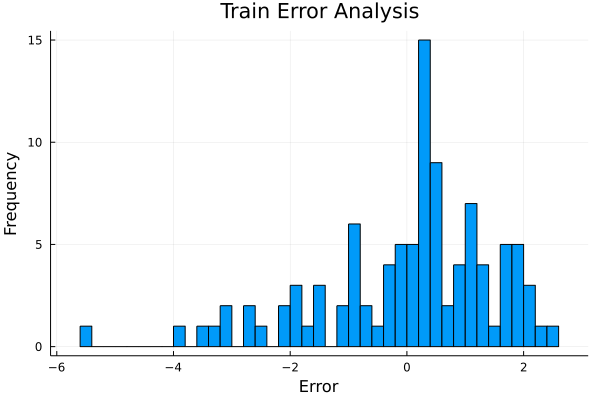

In [45]:
histogram(error_train, bins = 50, title = "Train Error Analysis", ylabel = "Frequency", xlabel = "Error",legend = false)


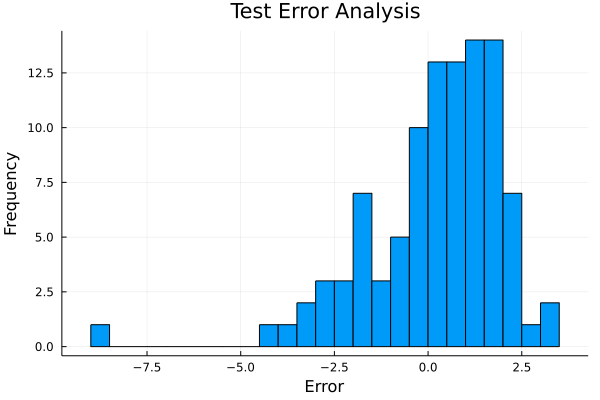

In [46]:
histogram(error_test, bins = 50, title = "Test Error Analysis", ylabel = "Frequency", xlabel = "Error",legend = false)


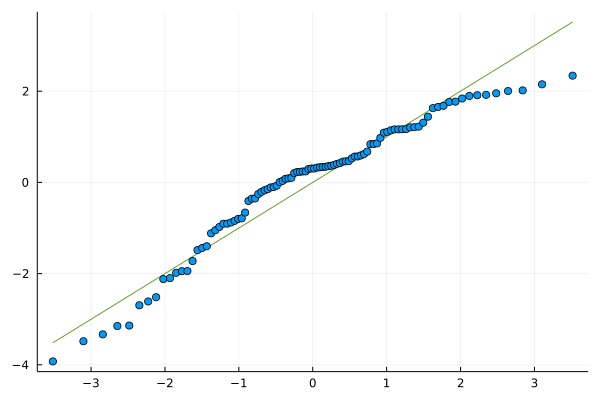

In [47]:
qqnorm(error_train)

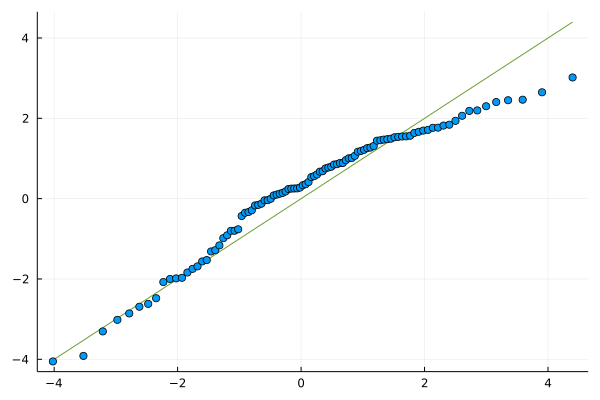

In [48]:
qqnorm(error_test)

In [49]:
X1_hat = value(X1)
X2_hat = value(X2)
W = beta0 .+ beta1*X1_hat .+ beta2*X2_hat .+ error_test

100-element Vector{Float64}:
 10.557879597212954
 14.863688730123005
 14.568469252622563
 16.374646133723893
 17.69020972405341
 14.711103264737389
 11.593281494076724
 13.081520822579508
 15.79786627346606
 16.451149956687043
 15.778504090828422
 14.25926818671684
 15.38584034929714
  ⋮
 14.865737802013228
 17.060661975653126
 15.212095740576178
 12.533912574624292
 13.811406653740404
 13.047695299315517
 14.789756781322314
 11.752726125246282
 16.090916380697784
 14.17836316398235
 16.157696506588437
 16.080686448438406

In [50]:
function profit(w)
    model = Model(CPLEX.Optimizer)
    set_silent(model)
    @variables(model, begin 
    Ya >= 0
    Yb >= 0
    end)
    @constraint(model,Ya <= 8)
    @constraint(model,2 * Yb <= 24)
    @constraint(model,3 * Ya + 2 * Yb <= 36)
    @constraint(model,Ya + Yb <= w)
    @objective(model, Max, 3*Ya + 5*Yb)
    optimize!(model)
    return objective_value(model)
end

profit (generic function with 1 method)

In [51]:
profits = zeros(100)
for i in 1:100
    profits[i] = profit(W[i])
end

In [52]:
MVSAE_avg = -0.1*X1_hat - 0.5*X2_hat + mean(profits)

40.201636409439686

In [53]:
function CI(x, conf_level=0.95)
    alpha = (1 - conf_level)
    tstar = quantile(TDist(length(x)-1), 1 - alpha/2)
    SE = std(x)/sqrt(length(x))

    lo, hi = mean(x) .+ [-1, 1] * tstar * SE
    return lo,hi
end

CI (generic function with 2 methods)

In [54]:
lo = -0.1*X1_hat - 0.5*X2_hat + CI(profits)[1]
hi = -0.1*X1_hat - 0.5*X2_hat + CI(profits)[2]
(lo,hi)

(39.02235761489088, 41.38091520398849)

# 2. SD

#### 2.1 Descriptive Analytics

#### #The same as SAA

#### 2.2 Prescriptive Analytics

In [18]:
model = direct_model(optimizer_with_attributes(
    CPLEX.Optimizer, CPLEX.PassNames() => true
))

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: DIRECT
Solver name: CPLEX

In [19]:
# Stage 1
@variables(model, begin 
    L1 <= X1 <= U1
    L2 <= X2 <= U2
    end)

(X1, X2)

In [20]:
@constraint(model,c1,X1 + X2 <= 200)
@constraint(model,c2,X1 - 0.5 * X2 >= 0)

c2 : X1 - 0.5 X2 ≥ 0.0

In [21]:
# Stage 2
@variables(model, begin 
    Ya >= 0
    Yb >= 0
    end)

(Ya, Yb)

In [22]:
@constraint(model,c3,Ya <= 8)
@constraint(model,c4,2 * Yb <= 24)
@constraint(model,c5,3 * Ya + 2 * Yb <= 36)
@constraint(model,c6,-beta1*X1 - beta2*X2 + Ya + Yb <= beta0)

c6 : -0.04549056742151611 X1 - 0.19561635306972333 X2 + Ya + Yb ≤ 2.688241698799437

In [23]:
@objective(model, Min, 0.1*X1 + 0.5*X2 - 3*Ya - 5*Yb)

0.1 X1 + 0.5 X2 - 3 Ya - 5 Yb

In [24]:
split_position = Position(c3, Ya)

Position(c3 : Ya ≤ 8.0, Ya)

In [25]:
rng = Random.MersenneTwister(123456789)

MersenneTwister(123456789)

In [26]:
rand(rng,error_train)

-2.6104238563124547

In [27]:
function mystoc()::OneRealization
    error = rand(rng,error_train)
    return OneRealization([Position(c6, "RHS") => beta0 + error])
end

mystoc (generic function with 1 method)

In [28]:
user_mean = [beta0]

1-element Vector{Float64}:
 2.688241698799437

In [29]:
solve_sd(model, split_position, user_mean, mystoc)

=== dumpCore ===
lp = 0xe67de60
type = 0
objsen = 1
rows	rname	senx	rhsx	mar=6
0	c1	L	200
1	c2	G	0
2	c3	L	8
3	c4	L	24
4	c5	L	36
5	c6	L	2.68824
cols	cname	ctype	bdl	bdu	mac=4
0	X1	C	4.1	296.4
1	X2	C	1.3	49.4
2	Ya	C	0	1e+20
3	Yb	C	0	1e+20
=== dumpTime ===
nr = 2
nc = 2
stgNames = TIME1 TIME2
row = 0 2
col = 0 2
=== dumpStoc ===
type = EXT_GENERATOR
sim = 1
numOmega = 1
numGroups = 1
groupBeg = 0
row	col	mean = ..
5	-1	2.688242

Optimal objective function value for (relaxed) mean value problem = -40.773028
Lower bounds computed = -80.533	
Starting two-stage stochastic decomposition.
Stage optimization problem for given input s_t = (x_t, omega_t) is in the following form : 

				 h_t(s_t) = c_t*x_t + min d_t*u_t
				                      s.t. D_t u_t = b_t - C_t x_t,

with the following linear dynamics: x_{t+} = a_{t+} + A_{t+}x_t + B_{t+}u_t.

------------------------------------------------------------------------------------------------------------------------------------

-------------

TwoSD.SDResult(Dict{ConstraintRef, Int64}(c4 : 2 Yb ≤ 24.0 => 4, c6 : -0.04549056742151611 X1 - 0.19561635306972333 X2 + Ya + Yb ≤ 2.688241698799437 => 6, c3 : Ya ≤ 8.0 => 3, c2 : X1 - 0.5 X2 ≥ 0.0 => 2, c1 : X1 + X2 ≤ 200.0 => 1, c5 : 3 Ya + 2 Yb ≤ 36.0 => 5), Dict{VariableRef, Int64}(X2 => 2, X1 => 1, Ya => 3, Yb => 4), Dict{Int64, ConstraintRef{Model, C, ScalarShape} where C}(5 => c5 : 3 Ya + 2 Yb ≤ 36.0, 4 => c4 : 2 Yb ≤ 24.0, 6 => c6 : -0.04549056742151611 X1 - 0.19561635306972333 X2 + Ya + Yb ≤ 2.688241698799437, 2 => c2 : X1 - 0.5 X2 ≥ 0.0, 3 => c3 : Ya ≤ 8.0, 1 => c1 : X1 + X2 ≤ 200.0), Dict{Int64, ConstraintRef{Model, C, ScalarShape} where C}(5 => c5 : 3 Ya + 2 Yb ≤ 36.0, 4 => c4 : 2 Yb ≤ 24.0, 6 => c6 : -0.04549056742151611 X1 - 0.19561635306972333 X2 + Ya + Yb ≤ 2.688241698799437, 2 => c2 : X1 - 0.5 X2 ≥ 0.0, 3 => c3 : Ya ≤ 8.0, 1 => c1 : X1 + X2 ≤ 200.0), [[183.682084, 16.317916], [180.656691, 19.343309], [182.772077, 17.227923], [183.121313, 16.878687], [179.990534, 20.009

In [30]:
#x1_opt = decision(X1, Ref(solve_sd(model, split_position, user_mean, mystoc)), CompromiseSolution)

In [31]:
#x1_opt

In [32]:
#x2_opt = decision(X2, Ref(solve_sd(model, split_position, user_mean, mystoc)), CompromiseSolution)

#### 2.3 Validation

In [33]:
X1_hat = 181.361720
X2_hat = 18.638280
W = beta0 .+ beta1*X1_hat .+ beta2*X2_hat .+ error_test

100-element Vector{Float64}:
 10.531897352134427
 14.837706485044478
 14.542487007544036
 16.348663888645362
 17.66422747897488
 14.685121019658862
 11.567299248998197
 13.05553857750098
 15.771884028387532
 16.425167711608516
 15.752521845749895
 14.233285941638313
 15.359858104218613
  ⋮
 14.839755556934701
 17.0346797305746
 15.18611349549765
 12.507930329545765
 13.785424408661877
 13.02171305423699
 14.763774536243787
 11.726743880167755
 16.064934135619257
 14.152380918903823
 16.131714261509913
 16.05470420335988

In [55]:
profits = zeros(100);
for i in 1:100
    profits[i] = profit(W[i])
end

In [56]:
MVSAE_avg = -0.1*X1_hat - 0.5*X2_hat + mean(profits)

40.201636409439686

In [57]:
lo = -0.1*X1_hat - 0.5*X2_hat + CI(profits)[1]
hi = -0.1*X1_hat - 0.5*X2_hat + CI(profits)[2]
(lo,hi)

(39.02235761489088, 41.38091520398849)